In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf



In [2]:
# define fixed parameters

#conductances
C_m = 1.0e-9

# volatages
V_leak = -40.0e-3 # 40 mV
V_Ca = 100.0e-3 # 100mV
V_k = -80.0e-3 # -80mV
V_h = -20.0e-3 # -20mV
V_syn = -75.0e-3 # -75mV

v_1 = 0.0 # 0mV
v_2 = 20.0e-3 # 20mV
v_3 = 0.0 # 0mV
v_4 = 15.0e-3 # 15mV
v_5 = 78.3e-3 # 78.3mV
v_6 = 10.5e-3 # 10.5mV
v_7 = -42.2e-3 # -42.2mV
v_8 = 87.3e-3 # 87.3mV
v_9 = 5.0e-3  # 5.0mV

v_th = -25.0e-3 # -25mV

# neuron specific conductances
g_Ca_f = 1.9e-2 * (1e-6) # 1.9e-2 \mu S
g_Ca_h = 1.7e-2 * (1e-6) # 1.7e-2 \mu S
g_Ca_s = 8.5e-3 * (1e-6) # 8.5e-3 \mu S

g_k_f  = 3.9e-2 * (1e-6) # 3.9e-2 \mu S
g_k_h  = 1.9e-2 * (1e-6) # 1.9e-2 \mu S
g_k_s  = 1.5e-2 * (1e-6) # 1.5e-2 \mu S

g_h_f  = 2.5e-2 * (1e-6) # 2.5e-2 \mu S
g_h_h  = 8.0e-3 * (1e-6) # 8.0e-3 \mu S
g_h_s  = 1.0e-2 * (1e-6) # 1.0e-2 \mu S

g_Ca = np.array([g_Ca_f, g_Ca_f, g_Ca_h, g_Ca_s, g_Ca_s])
g_k = np.array([g_k_f, g_k_f, g_k_h, g_k_s, g_k_s])
g_h = np.array([g_h_f, g_h_f, g_h_h, g_h_s, g_h_s])

g_leak = 1.0e-4 * (1e-6) # 1e-4 \mu S

phi_N = 2 # 0.002 ms^-1


    

## state representation

The state variable $x$ is comprised of three, five-dimensional state variables ($V_m$, $N$, and $H$) for each neuron.

$$x = \begin{bmatrix} V_m \\ N \\ H \end{bmatrix}$$
$$V_m = \begin{bmatrix} V_{m,f_1} \\ V_{m,f_2} \\ V_{m,h_n} \\ V_{m,s_1} \\ V_{m,s_2} \end{bmatrix} \hspace{1cm}
N = \begin{bmatrix} N_{f_1} \\ N_{f_2} \\ N_{h_n} \\ N_{s_1} \\ N_{s_2} \end{bmatrix} \hspace{1cm}
H = \begin{bmatrix} H_{f_1} \\ H_{f_2} \\ H_{h_n} \\ H_{s_1} \\ H_{s_2} \end{bmatrix} 
$$

In [3]:

def f(x, g_el, g_synA, g_synB):
    # x contains
    V_m = x[:5]
    N = x[5:10]
    H = x[10:]
    
    M_inf = 0.5*(1.0 + np.tanh((V_m - v_1)/ v_2))
    N_inf = 0.5*(1.0 + np.tanh((V_m - v_3)/v_4))
    H_inf = 1.0 / (1.0 + np.exp((V_m + v_5)/v_6))
                   
    S_inf = 1.0 / (1.0 + np.exp((v_th - V_m) / v_9))
    
    I_leak = g_leak*(V_m - V_leak)
    I_Ca = g_Ca*M_inf*(V_m - V_Ca)
    I_k = g_k*N*(V_m - V_k)
    I_h = g_h*H*(V_m - V_h)
                   
    I_elec = np.array([0.0, 
                       g_el*(V_m[1]-V_m[2]),
                       g_el*(V_m[2]-V_m[1] + V_m[2]-V_m[4]),
                       0.0,
                       g_el*(V_m[4]-V_m[2])])
                   
    I_syn = np.array([g_synB*S_inf[1]*(V_m[0] - V_syn),
                        g_synB*S_inf[0]*(V_m[1] - V_syn),
                        g_synA*S_inf[0]*(V_m[2] - V_syn) + g_synA*S_inf[3]*(V_m[2] - V_syn),
                        g_synB*S_inf[4]*(V_m[3] - V_syn),
                        g_synB*S_inf[3]*(V_m[4] - V_syn)])

    I_total = I_leak + I_Ca + I_k + I_h + I_elec + I_syn    
    
    lambda_N = (phi_N)*np.cosh((V_m - v_3)/(2*v_4))
    tau_h = (272.0 - (-1499.0 / (1.0 + np.exp((-V_m + v_7) / v_8)))) / 1000.0
    
    dVmdt = (1.0 / C_m)*(-I_total)
    dNdt = lambda_N*(N_inf - N)
    dHdt = (H_inf - H) / tau_h
    
    dxdt = np.concatenate((dVmdt, dNdt, dHdt), axis=0)
    return dxdt
                   

In [31]:
# parameters for the DSN
g_el = 1.5 * (1e-9) # .25 nS  (.25-7.5 nS) range
g_synA = 1.5 * (1e-9) # .25 nS  (.25-10 nS) range
g_synB = 5.0 * (1e-9) # .25 nS  (.25-10 nS) range

x_test = np.array(np.random.normal(0.0, 1.0, (15,)))

dxdt = f(x_test, g_el, g_synA, g_synB)
print(dxdt)


[-8.36294602e+01  1.45640857e+00 -2.92154867e+01  1.28644446e+01
  1.23031750e+01 -4.16655295e+15 -1.09777140e+00  2.17335571e+17
 -2.56071246e+13 -4.41559839e+06  4.50767505e-01  3.44251169e-01
 -2.31018725e-01  4.45120163e+00  2.33689519e+00]


In [32]:
V_m0 = -65.0e-3*np.ones((5,))
N_0 = 0.25*np.ones((5,))
H_0 = 0.1*np.ones((5,))
x0 = np.concatenate((V_m0, N_0, H_0), axis=0)
#x0 = np.array([0.7, -0.5, -0.5, 0.7, -0.7, \
#               0.05, 0.05, 0.035, 0.035, 0.035, \
#               0.1, 0.1, 0.1, 0.1, 0.1])
xs = [x0]
x = x0
T = 14000
dt = 0.001

for t in range(T):
    dxdt = f(x, g_el, g_synA, g_synB)
    x = dxdt*dt + x
    xs.append(x)
X = np.array(xs)
print(X.shape)

(14001, 15)


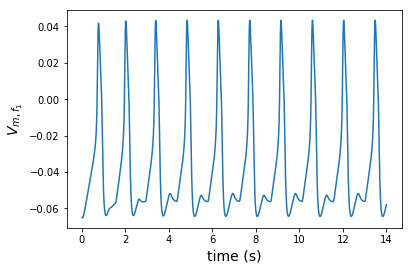

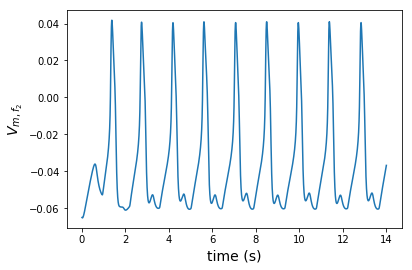

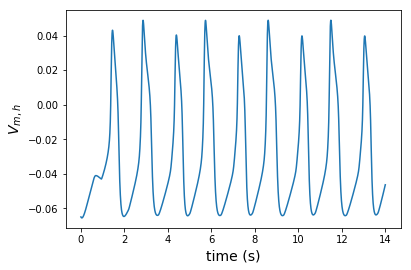

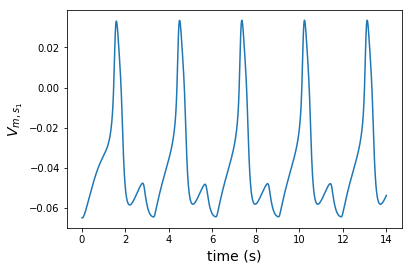

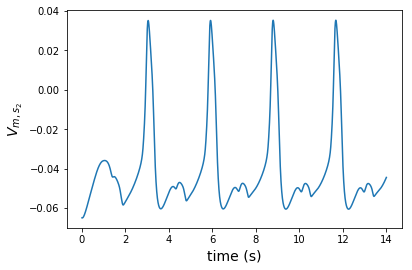

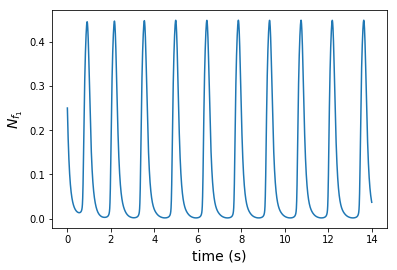

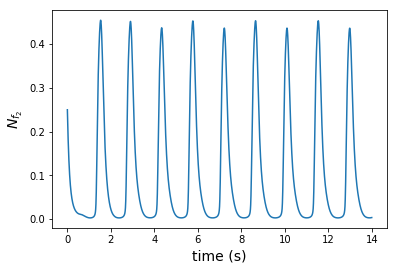

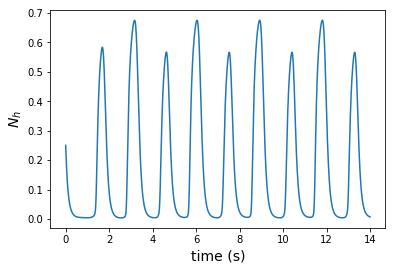

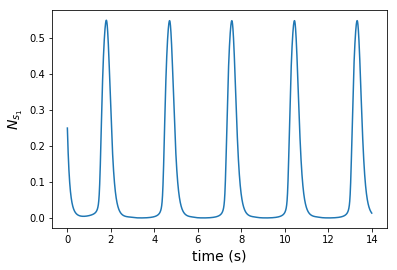

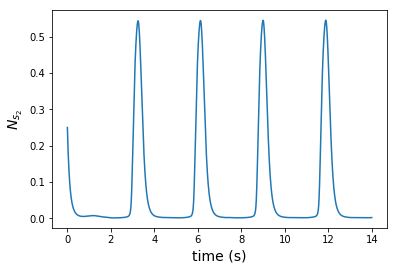

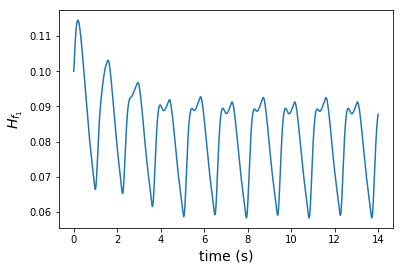

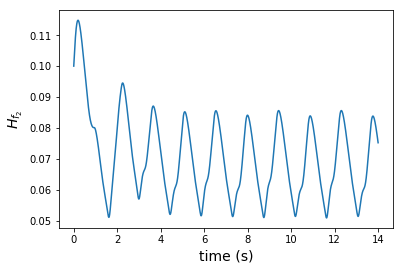

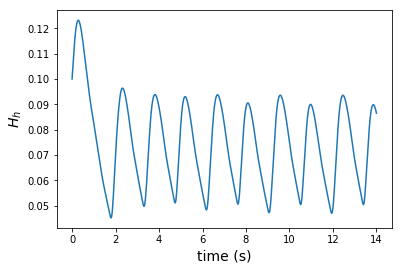

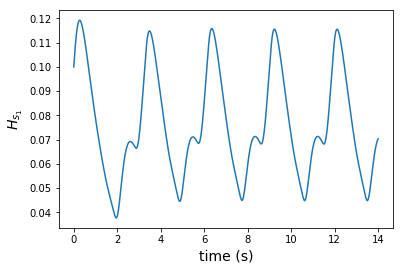

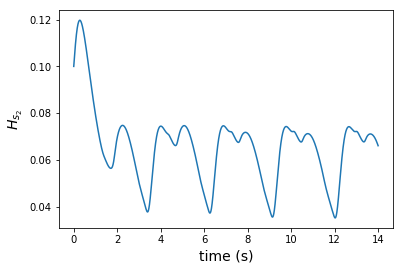

In [33]:
labels = [r'$V_{m,f_1}$', r'$V_{m,f_2}$', r'$V_{m,h}$', r'$V_{m,s_1}$', r'$V_{m,s_2}$', \
          r'$N_{f_1}$', r'$N_{f_2}$', r'$N_{h}$', r'$N_{s_1}$', r'$N_{s_2}$', \
          r'$H_{f_1}$', r'$H_{f_2}$', r'$H_{h}$', r'$H_{s_1}$', r'$H_{s_2}$']

fontsize = 14
t = np.arange(T+1) * dt
for i in range(15):
    plt.figure()
    plt.plot(t, X[:,i])
    plt.xlabel('time (s)', fontsize=fontsize)
    plt.ylabel(labels[i], fontsize=fontsize)
    plt.show()
    
x_fin = X[-1,:]

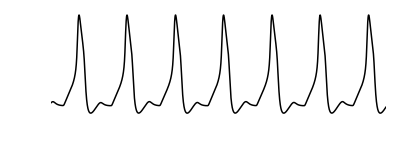

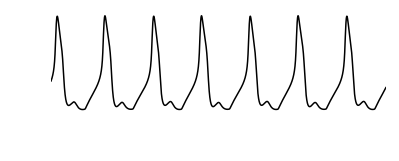

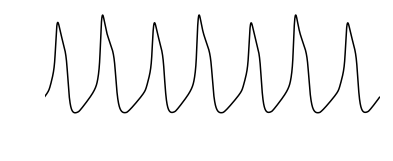

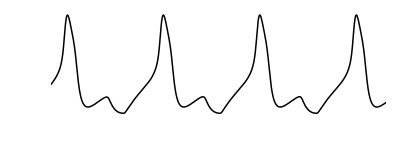

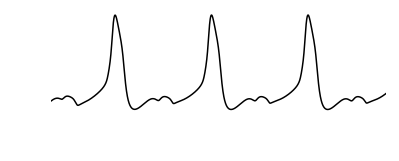

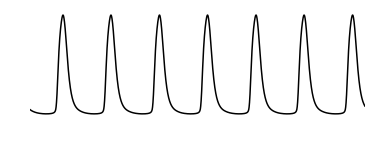

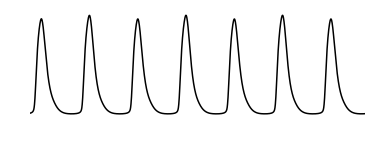

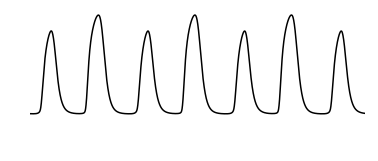

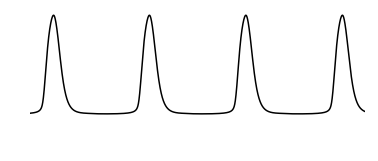

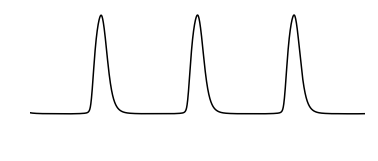

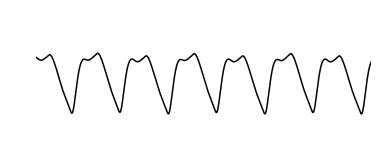

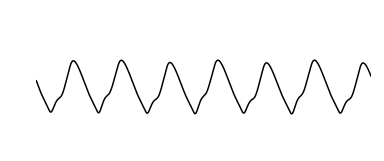

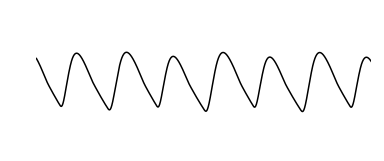

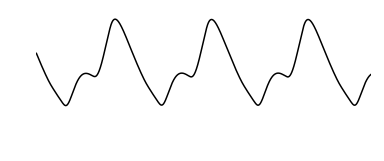

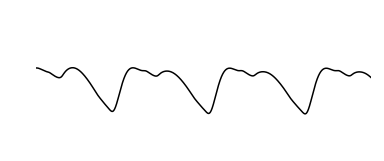

In [34]:
labels = ['f1', 'f2', 'hub', 's1', 's2']

fontsize = 14
t = np.arange(T+1) * dt
for i in range(15):
    fig = plt.figure(figsize=(6, 2))
    plt.plot(t, X[:,i], 'k-', linewidth=1.5)
    plt.xlabel('time (s)', fontsize=fontsize)
    plt.xlim([4, 14])
    plt.axis('off')
    if (i < 5):
        plt.savefig('/Users/sbittner/Documents/dsn/written/Journal2019/figs/fig1/STG_behavior_%s.png' % labels[i])
    #fig.patch.set_visible(False)
    plt.show()
    
    


[-4.         -3.91919192 -3.83838384 -3.75757576 -3.67676768 -3.5959596
 -3.51515152 -3.43434343 -3.35353535 -3.27272727 -3.19191919 -3.11111111
 -3.03030303 -2.94949495 -2.86868687 -2.78787879 -2.70707071 -2.62626263
 -2.54545455 -2.46464646 -2.38383838 -2.3030303  -2.22222222 -2.14141414
 -2.06060606 -1.97979798 -1.8989899  -1.81818182 -1.73737374 -1.65656566
 -1.57575758 -1.49494949 -1.41414141 -1.33333333 -1.25252525 -1.17171717
 -1.09090909 -1.01010101 -0.92929293 -0.84848485 -0.76767677 -0.68686869
 -0.60606061 -0.52525253 -0.44444444 -0.36363636 -0.28282828 -0.2020202
 -0.12121212 -0.04040404  0.04040404  0.12121212  0.2020202   0.28282828
  0.36363636  0.44444444  0.52525253  0.60606061  0.68686869  0.76767677
  0.84848485  0.92929293  1.01010101  1.09090909  1.17171717  1.25252525
  1.33333333  1.41414141  1.49494949  1.57575758  1.65656566  1.73737374
  1.81818182  1.8989899   1.97979798  2.06060606  2.14141414  2.22222222
  2.3030303   2.38383838  2.46464646  2.54545455  2.6

Text(0,0.5,'$\\tau_h$')

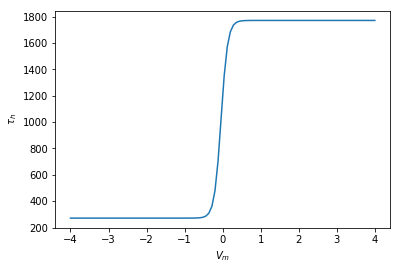

In [80]:
Vm = np.linspace(-4, 4, 100)
print(Vm)
tau_h = 272.0 - (-1499.0 / (1.0 + np.exp((-Vm + v_7) / v_8)))
plt.plot(Vm, tau_h)
plt.xlabel(r'$V_m$')
plt.ylabel(r'$\tau_h$')